## Road Surface Classifier Inference Example

This is a quick script to perform inference with our trained model, so we can see how well it works!

In [6]:
# Hacky way to get PLMCNN in scope
import sys; sys.path.append('./model')

import pathlib

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from model.data_augmentation import PreProcess
from model.custom_image_dataset import RoadSurfaceDataset
from model.data_augmentation import PreProcess

# Input model and checkpoint paths (checkpoint contains the weights for inference)
# Since these files are so large, they are not in source control.
# Reach out to me if you'd like them.
model_path = pathlib.Path('./results/20221003_044531Z/model.pth')
assert model_path.exists()
ckpt_path = pathlib.Path('./results/20221003_044531Z/model-epoch=07-val_loss=0.30283.ckpt')
assert ckpt_path.exists()
ds_path = pathlib.Path('/data/road_surface_classifier/dataset_simple/dataset_val.csv')
assert ds_path.exists()

Loading images from file...


100%|██████████| 20/20 [00:00<00:00, 733.88it/s]


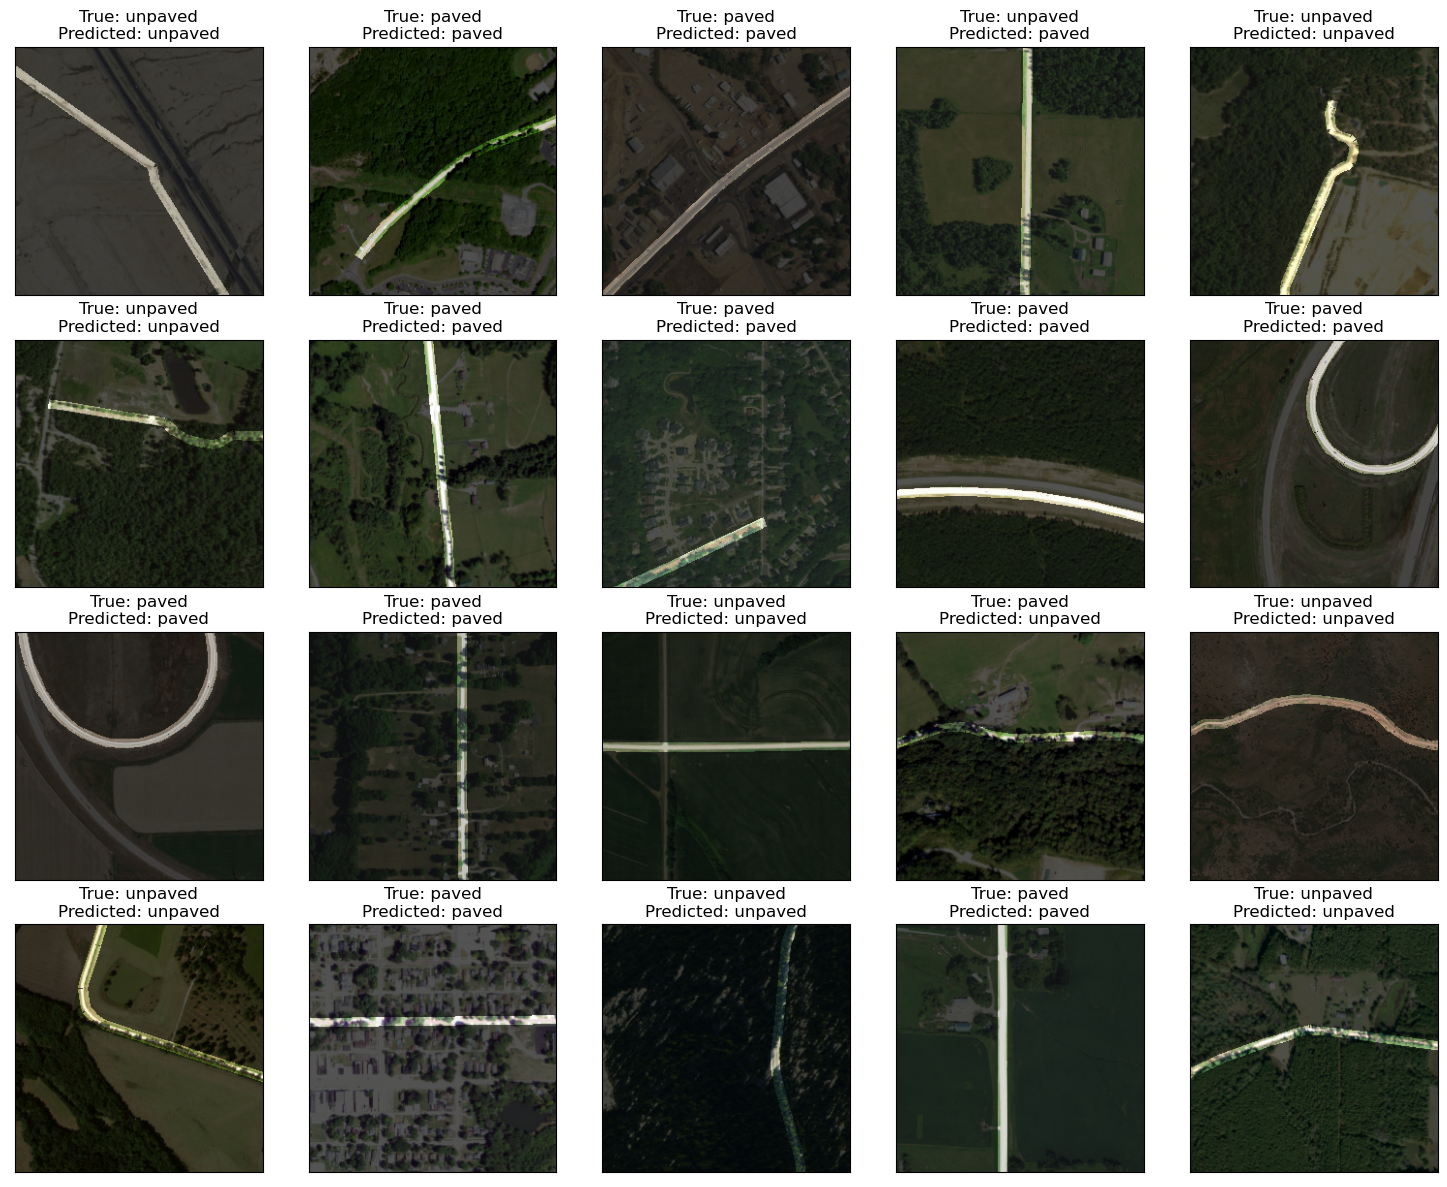

In [7]:
# Load model and checkpoint, set to eval (inference) mode
model = torch.load(model_path).load_from_checkpoint(ckpt_path)
model.eval()

# Get label array (it's built into model)
labels = model.__dict__.get('labels')

fig, ax = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(15, 12))
ax = ax.flatten() # type: ignore
fig.tight_layout()

# Import dataset
preprocess = PreProcess()
val_ds = RoadSurfaceDataset(str(ds_path),
    transform=preprocess, limit=20)
val_dl = DataLoader(val_ds, num_workers=16, batch_size=1, shuffle=True)

# Get truth and predictions using the dataloader
for i, (x, features) in enumerate(iter(val_dl)):

    # Get mask and image
    xm = x[:, 3:, :, :]
    x = x[:, :3, :, :]

    # Get true label
    y_true = features.numpy()[0]

    # Transform image in masl
    x_p = (np.moveaxis(x.numpy(), 1, -1)[0, ...] * 255.).astype(np.uint8)
    xm_p = np.moveaxis(xm.numpy(), 1, -1)[0, ...]

    # Predict with the model
    m, y_pred = model(x, xm)
    y_pred = torch.argmax(y_pred, axis=1).numpy()[0]     # type: ignore

    # Plot the result, highlighting the road with the mask
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title('True: %s\nPredicted: %s' % (labels[y_true], labels[y_pred]))
    ax[i].imshow(np.uint8(x_p * (0.33 + 0.67 * xm_p)))

plt.show()